<a href="https://colab.research.google.com/github/imation5212/Long-Short-Term-Memory-Model/blob/main/LSTM_Energy_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading date wrangling package
from datetime import datetime
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib as mpl
import tensorflow as tf

# Deep learning: 
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,LeakyReLU
#from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']=False

In [ ]:
# Reading the input data
#df = pd.read_excel('Load_Set.xlsx')
df = pd.read_excel('Thesis_data.xlsx')
df_energy_load=df.copy()
# Formating to datetime
#df_energy_load.reset_index(inplace=False)
df_energy_load['DateTime'] = pd.to_datetime(df_energy_load['DateTime'],format='%Y-%m-%dT%H:%M:%SZ')
df_energy_load = df_energy_load.set_index('DateTime')
df_energy_load = df_energy_load.asfreq('30min')
# Sorting the values
df_energy_load.sort_values('DateTime', inplace=True)

def create_features(Kenya):
    """
    create time series features based on time series index.
    """
    Kenya["hour"] = Kenya.index.hour
    Kenya["dayofweek"] = Kenya.index.day_of_week
    Kenya["month"] = Kenya.index.month
    return Kenya
df_energy_load = create_features(df_energy_load)
# Aggregating in 1Hour intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
#df_energy_load = df_energy_load.resample(rule='H', closed='left', label ='right').max()
df_energy_load = df_energy_load.resample(rule='H').max()
df_energy_load.index.freq
print(df_energy_load)
# Verify that a temporary index is complete
# ==============================================================================
print((df_energy_load.index == pd.date_range(start=df_energy_load.index.min(),
                              end=df_energy_load.index.max(),
                              freq=df_energy_load.index.freq)).all())

In [ ]:
df_energy_load.describe()

,MW,hour,dayofweek,month
count,8761.000000,8761.000000,8761.000000,8761.000000
mean,1426.688855,11.498687,3.002968,6.525397
std,253.189725,6.923277,1.998056,3.448357
min,779.971875,0.000000,0.000000,1.000000
25%,1224.865417,5.000000,1.000000,4.000000
50%,1476.438568,11.000000,3.000000,7.000000
75%,1579.657618,17.000000,5.000000,10.000000
max,2035.856230,23.000000,6.000000,12.000000


In [ ]:
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_energy_load)
data_scaled.shape[1]
data_scaled

'scaler=MinMaxScaler()\ndata_scaled=scaler.fit_transform(df_energy_load)\ndf_energy_load'

In [ ]:
class RNN_TS_model():
    """
    A class to create a deep time series model
    """
    def __init__(
        self,
        #data:pd.DataFrame,
        data,
        #features_var:list, 
        #target_var: float,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0,
        verbose=1
    ):

        self.data = data
        #self.X_var = features_var 
        #self.Y_var = target_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.verbose=verbose

    @staticmethod
    def create_multivariate_X_Y(ts_features: list,ts_target: list, lag:int) -> list:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models

        Window_length is the lag argument
        The stride and sampling rate are fixed at 1
        """
        X_data, Y_data = [], []
        

        if len(ts_features) - lag <= 0:        
            X_data.append(ts_features)
        else:
            for i in range(len(ts_features) - lag):            
                X_data.append(ts_features[i:(i + lag)])
            for i in range(len(ts_target) - lag):            
                Y_data.append(ts_target[i + lag])

        X, Y = np.array(X_data), np.array(Y_data)
        print("X.shape[0]: ",X.shape[0])
        print("X.shape[1]: ",X.shape[1])
        print("X.shape[2]: ",X.shape[2])
        
        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0],X.shape[1],X.shape[2], 1))

        return X, Y         

    def create_multivariate_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the features to be incorporated in the train data set
        #x=self.data[self.X_var].to_numpy().tolist()
        x=self.data
        """
        x=self.data[['MW','Holiday','hour','dayofweek','month']].to_numpy().tolist()
        
        """

        # Extracting the main variable we want to model/forecast
        """
        y=self.data['MW'].tolist()
        """
        #y = self.data[self.Y_var].tolist()
        y = self.data[:,0]

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_multivariate_X_Y(x,y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test
    def LSTM_multivariate_model1(self):
            """
            A method to fit the LSTM model 
            """
            # Getting the data
            X_train, X_test, Y_train, Y_test = self.create_multivariate_data_for_NN()        

            # Defining the model
            model = Sequential()
            model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')



            # Defining the model parameter dict 
            keras_dict = {
                'x': X_train,
                'y': Y_train,
                'batch_size': self.batch_size,
                'epochs': self.epochs,
                'validation_data':X_test,
                'shuffle': False,
                'verbose':self.verbose
            }

            if self.train_test_split > 0:
                keras_dict.update({
                    'validation_data': (X_test, Y_test)
                })

            # Fitting the model 
            model.fit(
                **keras_dict
            )

            # Saving the model to the class 
            self.model = model

            return model
    def LSTM_multivariate_model2(self):
            # Getting the data
            X_train, X_test, Y_train, Y_test = self.create_multivariate_data_for_NN()

            # Defining the model2
            model2=Sequential()
            model2.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
            model2.add(LeakyReLU(alpha=0.5))
            model2.add(LSTM(self.LSTM_layer_depth,return_sequences=True))
            model2.add(LeakyReLU(alpha=0.5))
            model2.add(Dropout(0.3))
            model2.add(LSTM(64,return_sequences=False))
            model2.add(Dropout(0.3))
            model2.add(Dense(1))
            
            model2.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

            early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
            patience=2,mode='min')

            # Defining the model2 parameter dict 
            keras_dict2 = {
                'x': X_train,
                'y': Y_train,
                'batch_size': self.batch_size,
                'epochs': self.epochs,
                'validation_data':X_test,
                'shuffle': False,
                'verbose':self.verbose,
                'callbacks':[early_stopping]
            }

            if self.train_test_split > 0:
                keras_dict2.update({
                    'validation_data': (X_test, Y_test)
                })

            # Fitting the model 
            model2.fit(
                **keras_dict2
            )
            # Saving the model to the class 
            self.model2 = model2

            return model2
            
    def predict(self) -> list:
          """
          A method to predict using the test data used in creating the class
          """
          #yhat = []

          if(self.train_test_split > 0):
          
              # Getting the last n time series 
              _, X_test, _, yTest = self.create_multivariate_data_for_NN()        

              # Making the prediction list 
              yhat = self.model.predict(X_test)

          return X_test,yTest,yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_multivariate_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat
    

In [ ]:
deep_learner=RNN_TS_model(
    data=data_scaled,
    #features_var=['MW','hour','dayofweek','month'],
    #target_var="MW",
    lag=24,
    LSTM_layer_depth=128,
    epochs=70, 
    batch_size=32,
    train_test_split=0.2,
    verbose=1)        

In [ ]:
model1=deep_learner.LSTM_multivariate_model1()

In [ ]:
model2=deep_learner.LSTM_multivariate_model2()

In [ ]:
xtest,ytest,yhat=deep_learner.predict()

In [ ]:
xtest,ytest,yhat=deep_learner.predict()

In [ ]:
rev_transformation=scaler.inverse_transform(df_pred)
rev_transformation

In [ ]:
# Constructing the insample forecast dataframe
insample_forecast=df_energy_load.tail(len(yhat)).copy()

insample_forecast.count()

In [ ]:
insample_forecast['Forecast']=rev_transformation[:,0]
insample_forecast.reset_index(inplace=True)
insample_forecast

In [ ]:
insample_forecast.set_index('DateTime')[['MW','Forecast']].plot()

In [ ]:
ytest

In [ ]:
yhat

In [ ]:
mse=mean_squared_error(insample_forecast["MW"],insample_forecast["Forecast"])
print("MSE: ", mse)
rmse=np.sqrt(mse)
print("RMSE: ", rmse)
r2=r2_score(ytest,yhat)
print("R2: ",r2)

In [ ]:
# Creating the model using full data and forecasting n steps
aheaddeep_learner = DeepModelTS(
data=df_energy_load,
Y_var='MW',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0,
verbose=2
)
"""
# Creating the model using full data and forecasting n steps aheaddeep_learner = DeepModelTS(
data=d,
Y_var='DAYTON_MW',
lag=48,
LSTM_layer_depth=64,
epochs=70,
train_test_split=0.15
)

"""
# Fitting the model
deep_learner.LSTModel()


Epoch 1/70
1486/1486 - 34s - loss: 296166.8750 - val_loss: 135476.7500 - 34s/epoch - 23ms/step
Epoch 2/70
1486/1486 - 30s - loss: 88276.0547 - val_loss: 45980.9648 - 30s/epoch - 20ms/step
Epoch 3/70
1486/1486 - 31s - loss: 55727.2500 - val_loss: 23745.5137 - 31s/epoch - 21ms/step
Epoch 4/70
1486/1486 - 32s - loss: 22971.3867 - val_loss: 21035.8633 - 32s/epoch - 22ms/step
Epoch 5/70
1486/1486 - 32s - loss: 19157.1230 - val_loss: 16902.9902 - 32s/epoch - 21ms/step
Epoch 6/70
1486/1486 - 28s - loss: 16532.2148 - val_loss: 13933.3018 - 28s/epoch - 19ms/step
Epoch 7/70
1486/1486 - 30s - loss: 15796.3955 - val_loss: 21347.9551 - 30s/epoch - 20ms/step
Epoch 8/70
1486/1486 - 29s - loss: 15694.0684 - val_loss: 14227.5938 - 29s/epoch - 19ms/step
Epoch 9/70
1486/1486 - 30s - loss: 24759.6719 - val_loss: 12415.2197 - 30s/epoch - 20ms/step
Epoch 10/70
1486/1486 - 29s - loss: 38535.4453 - val_loss: 34619.1523 - 29s/epoch - 19ms/step
Epoch 11/70
1486/1486 - 30s - loss: 20941.2090 - val_loss: 15265.04

In [ ]:
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]
yhat

1/1 [==============================] - 0s 24ms/step


[array([[1232.3186]], dtype=float32),
 array([[1179.469]], dtype=float32),
 array([[1136.2432]], dtype=float32),
 array([[1091.3352]], dtype=float32),
 array([[1061.469]], dtype=float32),
 array([[1038.8263]], dtype=float32),
 array([[1024.264]], dtype=float32),
 array([[1012.0854]], dtype=float32),
 array([[1011.6814]], dtype=float32),
 array([[1011.7156]], dtype=float32),
 array([[1020.6927]], dtype=float32),
 array([[1039.4468]], dtype=float32),
 array([[1067.799]], dtype=float32),
 array([[1094.8805]], dtype=float32),
 array([[1121.9906]], dtype=float32),
 array([[1168.4635]], dtype=float32),
 array([[1213.304]], dtype=float32),
 array([[1271.0635]], dtype=float32),
 array([[1315.3607]], dtype=float32),
 array([[1345.5403]], dtype=float32),
 array([[1367.618]], dtype=float32),
 array([[1378.093]], dtype=float32),
 array([[1376.9963]], dtype=float32),
 array([[1375.0852]], dtype=float32),
 array([[1372.477]], dtype=float32),
 array([[1373.4011]], dtype=float32),
 array([[1375.693]],

In [ ]:
#fc_test=df_energy_load.tail(len(yhat)).copy()
#fc_test=pd.to_datetime(fc_test['Time']) #+ pd.to_timedelta(fc_test['Day'], unit='d')
#df['Date'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Day'], unit='d')
#fc.reset_index(inplace=True)
#fc['forecast'] = yhat
#fc_test

,Date,MW,Holiday
Time,,,
2021-11-07 09:30:00,2021-11-07,1361.674976,False
2021-11-07 10:00:00,2021-11-07,1371.293556,False
2021-11-07 10:30:00,2021-11-07,1332.321820,False
2021-11-07 11:00:00,2021-11-07,1275.670091,False
2021-11-07 11:30:00,2021-11-07,1295.331307,False
...,...,...,...
2021-12-31 21:30:00,2021-12-31,1635.098615,True
2021-12-31 22:00:00,2021-12-31,1528.430615,True
2021-12-31 22:30:00,2021-12-31,1447.592615,True


#**Model option 2**

In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from math import sqrt

import pandas as pd
from numpy import concatenate
from pandas import read_excel,Timestamp
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')
color_pal=sns.color_palette()

In [ ]:
# convert series to supervised learning
def series_to_supevised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#**Data Preparation**

In [ ]:
dataset = read_excel('Energy_Load_Dataset.xlsx')
#dataset.head()
data_plot = dataset.copy()
data_plot['Time'] = pd.to_datetime(data_plot['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data_plot = data_plot.set_index('Time')
data_plot = data_plot.asfreq('30min')
data_plot = data_plot.sort_index()
#data_plot.head()
# Verify that a temporary index is complete
# ==============================================================================
val=(data_plot.index == pd.date_range(start=data_plot.index.min(),
                              end=data_plot.index.max(),
                              freq=data_plot.index.freq)).all()
print("isTemporary Index Complete: ",val)


val

isTemporary Index Complete:  True


True

In [ ]:
def create_features(Kenya):
    """
    create time series features based on time series index.
    """
    Kenya["hour"] = Kenya.index.hour
    Kenya["dayofweek"] = Kenya.index.day_of_week
    Kenya["month"] = Kenya.index.month
    return Kenya
data_plot = create_features(data_plot)
data_plot.head(100)

,Date,MW,Holiday,hour,dayofweek,month
Time,,,,,,
2021-01-01 00:00:00,2021-01-01,988.422459,True,0,4,1
2021-01-01 00:30:00,2021-01-01,1109.096459,True,0,4,1
2021-01-01 01:00:00,2021-01-01,1070.456459,True,1,4,1
2021-01-01 01:30:00,2021-01-01,1020.408459,True,1,4,1
2021-01-01 02:00:00,2021-01-01,988.320459,True,2,4,1
...,...,...,...,...,...,...
2021-01-02 23:30:00,2021-01-02,1143.679875,False,23,5,1
2021-01-03 00:00:00,2021-01-03,976.420458,False,0,6,1
2021-01-03 00:30:00,2021-01-03,1015.978458,False,0,6,1


First_quarter dates      : 2021-01-01 00:00:00 --- 2021-03-31 23:30:00
Second_quarter dates : 2021-03-31 23:30:00 --- 2021-06-30 23:30:00
Third_quarter dates       : 2021-06-30 23:30:00 --- 2021-09-30 23:30:00
Fourth_quarter dates       : 2021-09-30 23:30:00 --- 2021-12-31 23:30:00


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


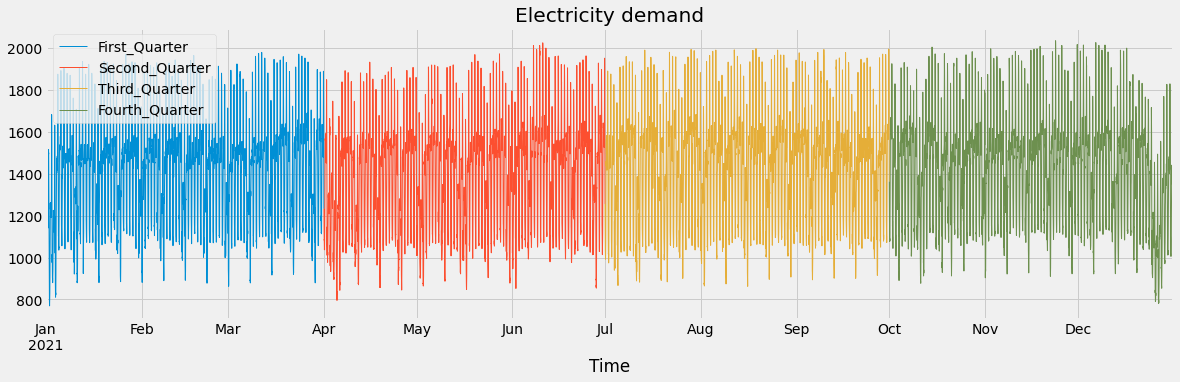

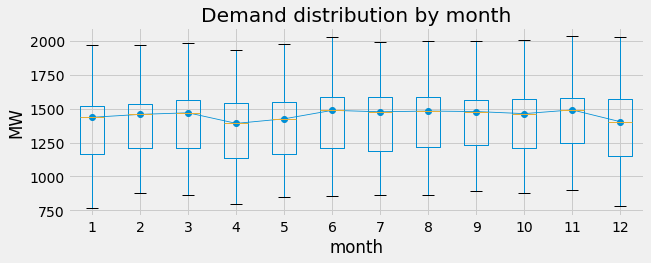

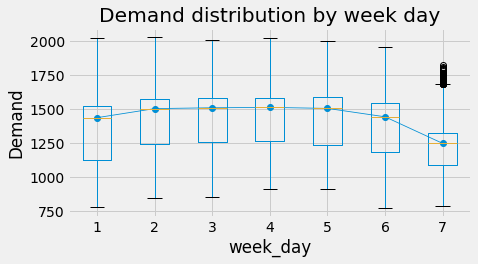

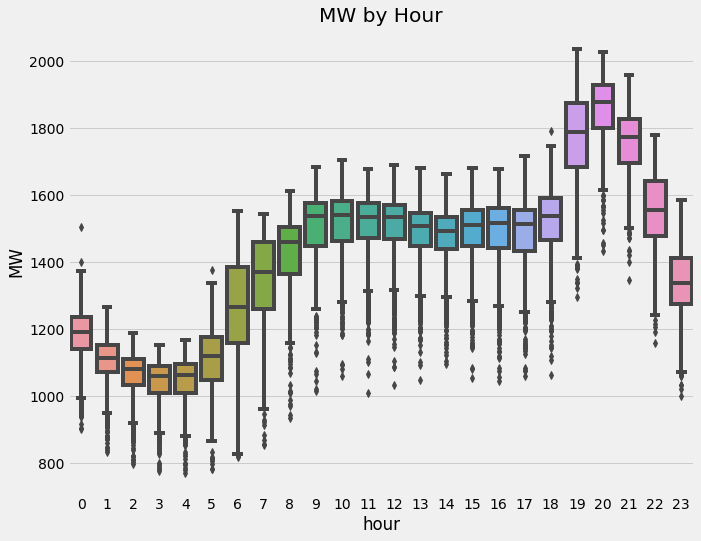

ValueError: ignored

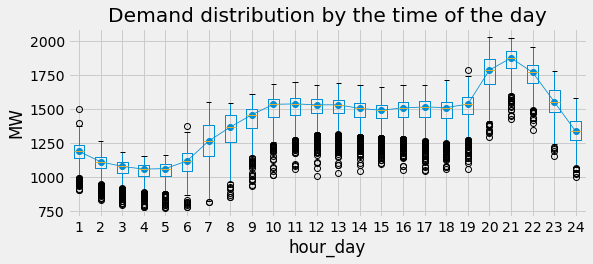

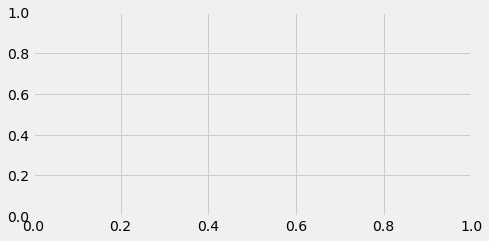

In [ ]:
# Split data into train-val-test
# ==============================================================================
#data_plot = data_plot.loc['2021-01-01 00:00:00': ]
first_quarter='2021-03-31 23:30:00'
second_quarter='2021-06-30 23:30:00'
third_quarter='2021-09-30 23:30:00'
fourth_quarter='2021-12-31 23:30:00'

first_quarter_data= data_plot.loc[: first_quarter, :]
second_quarter_data   = data_plot.loc[first_quarter:second_quarter, :]
third_quarter_data  = data_plot.loc[second_quarter:third_quarter, :]
fourth_quarter_data  = data_plot.loc[third_quarter:, :]

print(f"First_quarter dates      : {first_quarter_data.index.min()} --- {first_quarter_data.index.max()}")
print(f"Second_quarter dates : {second_quarter_data.index.min()} --- {second_quarter_data.index.max()}")
print(f"Third_quarter dates       : {third_quarter_data.index.min()} --- {third_quarter_data.index.max()}")
print(f"Fourth_quarter dates       : {fourth_quarter_data.index.min()} --- {fourth_quarter_data.index.max()}")

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 5))
first_quarter_data.MW.plot(ax=ax, label='First_Quarter', linewidth=1)
second_quarter_data.MW.plot(ax=ax, label='Second_Quarter', linewidth=1)
third_quarter_data.MW.plot(ax=ax, label='Third_Quarter', linewidth=1)
fourth_quarter_data.MW.plot(ax=ax, label='Fourth_Quarter', linewidth=1)

ax.set_title('Electricity demand')
ax.legend()

# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3.5))
data_plot['month'] = data_plot.index.month
data_plot.boxplot(column='MW', by='month', ax=ax,)
data_plot.groupby('month')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('MW')
ax.set_title('Demand distribution by month')
fig.suptitle('');

# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data_plot['week_day'] = data_plot.index.day_of_week + 1
data_plot.boxplot(column='MW', by='week_day', ax=ax)
data_plot.groupby('week_day')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data_plot, x="hour", y= "MW")
ax.set_title("MW by Hour")
plt.show()

fig, ax = plt.subplots(figsize=(9, 3.5))
data_plot['hour_day'] = data_plot.index.hour + 1
data_plot.boxplot(column='MW', by='hour_day', ax=ax)
data_plot.groupby('hour_day')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('MW')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('');

# Violinplot for Holiday and non Holiday demand
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
               data_plot= data_plot.assign(Holiday = data_plot.Holiday.astype(str)),
               x= 'MW',y= 'Holiday',
               palette = 'tab10',ax= ax)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('MW')
ax.set_ylabel('Holiday');

Number of rows with missing values:                       0.0
reframed:  (17519, 3) reframed head:     var1(t-1)  var2(t-1)  var3(t-1)
1   0.172855        1.0   0.000000
2   0.268150        1.0   0.000057
3   0.237636        1.0   0.000114
4   0.198114        1.0   0.000171
5   0.172775        1.0   0.000228


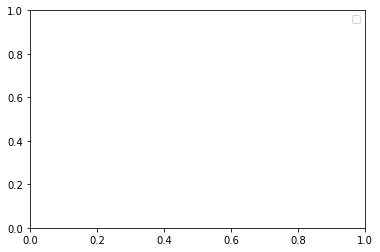

165/165 [==============================] - 1s 1ms/step
MSE: 0.3197437716458639
RMSE: 0.5654589035870458
R2: -2.909073023824895


In [ ]:
new_dataset=pd.Series(dataset['Time'].apply(pd.Timestamp.timestamp))
dataset= pd.concat([dataset,new_dataset.rename("New_Time_Timesatmp")], axis=1)
dataset=dataset.drop(columns=['Date','Time'])#,'Time_str'])
print(f"Number of rows with missing values: \
                      {dataset.isnull().any(axis=1).mean()}")# Checks for null/empty values
values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supevised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[3,4,5]], axis=1, inplace=True)
print("reframed: ", reframed.shape, "reframed head: ", reframed.head())

# split into train and test sets
values = reframed.values

X = values[:,:3]
Y = values[:,2]

# Split Data to Train and Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=0)

# reshape input to be 3D [samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))

# network architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit
history = model.fit(X_Train, Y_Train, epochs=70, batch_size=10, validation_data=(X_Test, Y_Test), verbose=2, shuffle=False)
# plot history
#plt.plot(history.history['loss'], label='Train')
#plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

# Model Evalaution
yhat=model.predict(X_Test)
mse = mean_squared_error(Y_Test, yhat)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(Y_Test, yhat)
print("R2:", r2)